<a href="https://colab.research.google.com/github/lioravraham/Adv_computational_learning_and_data_analysis/blob/main/PS3_2_207752643.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Machine Translation with Attention

Advanced Learning Fall 2024.   
Last updated: 2025-01-12


*For* SUBMISSION:   

Please upload the complete and executed `ipynb` to your git repository. Verify that all of your output can be viewed directly from github, and provide a link to that git file below.

~~~
STUDENT ID: 207752643
~~~

~~~
STUDENT GIT LINK:  https://github.com/lioravraham/Adv_computational_learning_and_data_analysis
~~~
In Addition, don't forget to add your ID to the files, and upload to moodle the html version:    
  
`PS3_Attention_2_2024_ID_[207752643].html`   




# Note
this html contain only part2 of ex3 (there was a problem in the runing time and spilt the ex to 2 notebooks help...)

## Part 2: A language translation model with attention

In this part of the problem set we are going to implement a translation with a Sequence to Sequence Network and Attention model.

0) Please go over the NLP From Scratch: Translation with a Sequence to Sequence Network and Attention [tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html). This attention model is very similar to what was learned in class (Luong), but a bit different. What are the main differences between  Badahnau and Luong attention mechanisms?    



1.a) Using `!wget`, `!unzip` , download and extract the [hebrew-english](https://www.manythings.org/anki/) sentence pairs text file to the Colab `content/`  folder (or local folder if not using Colab).
1.b) The `heb.txt` must be parsed and cleaned (see tutorial for requirements or change the code as you see fit).   


2.a) Use the tutorial example to build  and train a Hebrew to English translation model with attention (using the parameters in the code cell below). Apply the same `eng_prefixes` filter to limit the train/test data.   
2.b) Evaluate your trained model randomly on 20 sentences.  
2.c) Show the attention plot for 5 random sentences.  


3) Do you think this model performs well? Why or why not? What are its limitations/disadvantages? What would you do to improve it?  


4) Using any neural network architecture of your liking, build  a model with the aim to beat the model in 2.a. Compare your results in a meaningful way, and add a short explanation to why you think/thought your suggested network is better.

0) The main differences between Bahdanau and Luong attention mechanisms are:

1. Bahdanau uses a neural network for computing attention weights, while Luong uses simpler mathematical approaches.

2. Luong attention uses only the current decoder state to compute attention weights, whereas Bahdanau uses both the previous attention state and current decoder state.

3. Bahdanau attention concatenates forward and backward source hidden states, while Luong uses top hidden layer states in both encoder and decoder.

4. Luong introduced global and local attention variants, with local attention focusing on a subset of source words, which can be beneficial for long sequences.

In [ ]:
# use the following parameters:
MAX_LENGTH = 10
hidden_size = 128
epochs = 50
batch_size = 32

SOLUTION:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files
import zipfile
import unicodedata
import re
import os
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import random

from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


In [ ]:
with zipfile.ZipFile("/content/heb-eng.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

# rename file to expected name
os.rename("/content/heb.txt", "/content/eng-heb.txt")

In [ ]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z\u0590-\u05FF!?]+", r" ", s)
    return s.strip()

def readLangs(lang1, lang2, reverse=False):
  print("Reading lines...")

  # Read the file and split into lines
  lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
      read().strip().split('\n')

  # Split every line into pairs and normalize
  pairs = [[normalizeString(s) for s in l.split('\t')[:2]] for l in lines]

  # Reverse pairs, make Lang instances
  if reverse:
      pairs = [list(reversed(p)) for p in pairs]
      input_lang = Lang(lang2)
      output_lang = Lang(lang1)
  else:
      input_lang = Lang(lang1)
      output_lang = Lang(lang2)

  return input_lang, output_lang, pairs

In [ ]:
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'heb', True)

Reading lines...
Read 128133 sentence pairs
Trimmed to 9320 sentence pairs
Counting words...
Counted words:
heb 6206
eng 3067


Preparing Training Data

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def get_dataloader(batch_size):
  input_lang, output_lang, pairs = prepareData('eng', 'heb', True)

  n = len(pairs)
  input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
  target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

  for idx, (inp, tgt) in enumerate(pairs):
      inp_ids = indexesFromSentence(input_lang, inp)
      tgt_ids = indexesFromSentence(output_lang, tgt)
      inp_ids.append(EOS_token)
      tgt_ids.append(EOS_token)
      input_ids[idx, :len(inp_ids)] = inp_ids
      target_ids[idx, :len(tgt_ids)] = tgt_ids

  train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                              torch.LongTensor(target_ids).to(device))

  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
  return input_lang, output_lang, train_dataloader

Encoder

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

Decoder

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [ ]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

Training

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [ ]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
              print_every=100, plot_every=100):
  start = time.time()
  plot_losses = []
  print_loss_total = 0  # Reset every print_every
  plot_loss_total = 0  # Reset every plot_every

  encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
  decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
  criterion = nn.NLLLoss()

  for epoch in range(1, n_epochs + 1):
      loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
      print_loss_total += loss
      plot_loss_total += loss

      if epoch % print_every == 0:
          print_loss_avg = print_loss_total / print_every
          print_loss_total = 0
          print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                      epoch, epoch / n_epochs * 100, print_loss_avg))

      if epoch % plot_every == 0:
          plot_loss_avg = plot_loss_total / plot_every
          plot_losses.append(plot_loss_avg)
          plot_loss_total = 0

  showPlot(plot_losses)

Evaluation

In [ ]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Traning and Evaluating

In [ ]:
input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

Reading lines...
Read 128133 sentence pairs
Trimmed to 9320 sentence pairs
Counting words...
Counted words:
heb 6206
eng 3067
0m 40s (- 10m 2s) (5 6%) 1.7678
1m 15s (- 8m 46s) (10 12%) 0.9398
1m 50s (- 7m 58s) (15 18%) 0.5551
2m 25s (- 7m 16s) (20 25%) 0.3256
3m 0s (- 6m 36s) (25 31%) 0.1907
3m 35s (- 5m 59s) (30 37%) 0.1181
4m 11s (- 5m 23s) (35 43%) 0.0812
4m 47s (- 4m 47s) (40 50%) 0.0610
5m 23s (- 4m 11s) (45 56%) 0.0500
5m 58s (- 3m 35s) (50 62%) 0.0421
6m 34s (- 2m 59s) (55 68%) 0.0373
7m 9s (- 2m 23s) (60 75%) 0.0341
7m 44s (- 1m 47s) (65 81%) 0.0317
8m 20s (- 1m 11s) (70 87%) 0.0296
8m 55s (- 0m 35s) (75 93%) 0.0275
9m 30s (- 0m 0s) (80 100%) 0.0268


In [ ]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder, n=20)

> אני הכבשה השחורה של המשפחה
= i m the black sheep of the family
< i m the black sheep of the family <EOS>

> את חוששת נכון ?
= you re scared aren t you ?
< you re not scared aren t you ? <EOS>

> אנו עדיין מתלבטים
= we re still deliberating
< we re sorry <EOS>

> שנינו סופרים
= we re both writers
< we re both writers <EOS>

> אני לא כל כך מיואשת עדיין
= i m not that desperate yet
< i m not that desperate yet <EOS>

> היא תמיד מתלוננת על השכר הנמוך שלי
= she is always complaining about my small salary
< she is wearing an expensive necklace on time <EOS>

> אני מצטער על אתמול בלילה
= i m sorry about last night
< i m sorry about last night <EOS>

> הוא המקרין בתאטרון
= he s the projectionist at the theater
< he s the projectionist at the theater theater theater the

> את נבונה אך לא נבונה די
= you re clever but not clever enough
< you re clever but not clever enough <EOS>

> אנו מוצנעים
= we re discreet
< we re discreet <EOS>

> אתה במעצר
= you are under arrest
< you are under arrest arr

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    input_tokens = [''] + input_sentence.split(' ') + ['<EOS>']
    output_tokens = [''] + output_words
    ax.set_xticks(range(len(input_tokens)))
    ax.set_yticks(range(len(output_tokens)))
    ax.set_xticklabels([word[::-1] if word != "<EOS>" else word for word in input_tokens])
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    display(fig)
    plt.close(fig)

def evaluateAndShowAttention(input_sentence):
  output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
  print('input =', input_sentence)
  print('output =', ' '.join(output_words))
  print("Attention:")
  showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

Reading lines...
Read 128133 sentence pairs
Trimmed to 9320 sentence pairs
Counting words...
Counted words:
heb 6206
eng 3067

input = אני מחכה לחברה שלי
output = i m waiting for my girlfriend <EOS>
Attention:


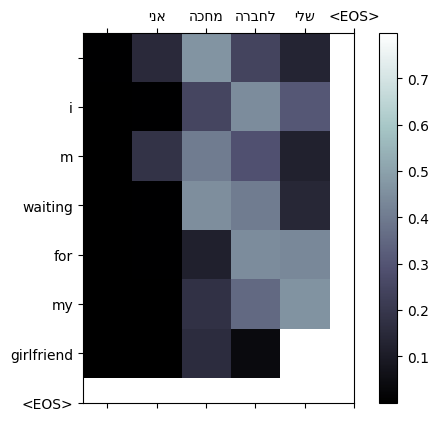

input = אני כל כך נרגש
output = i m so excited <EOS>
Attention:


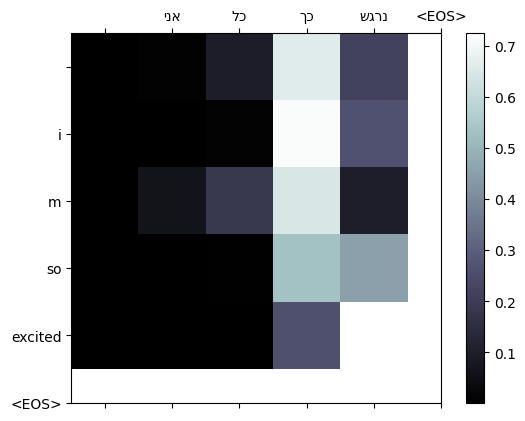

input = אתה רק סטודנט
output = you re just a student <EOS>
Attention:


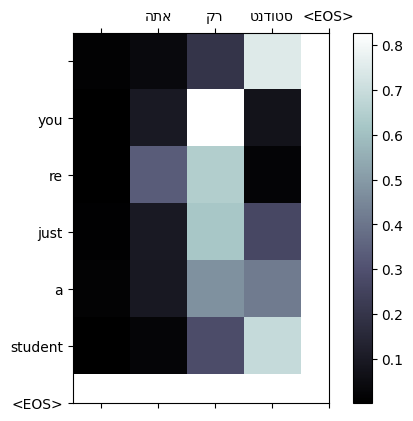

input = אני עוד לא מוכן לכך
output = i m not ready yet with this <EOS>
Attention:


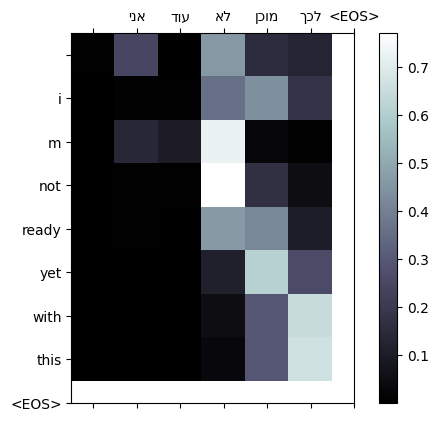

input = אתם יוצאים מן הכלל
output = you re extraordinary <EOS>
Attention:


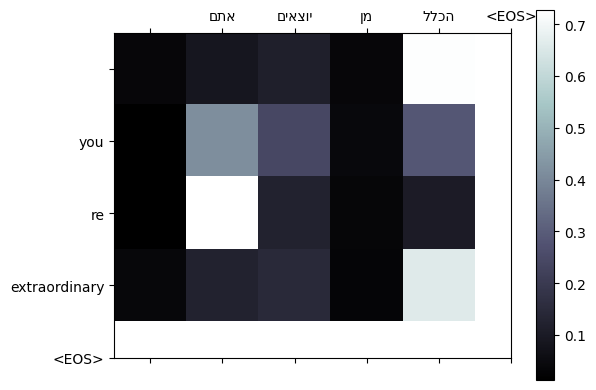

In [ ]:
_, _, pairs = prepareData('eng', 'heb', True)
print()
for i in range(5):
  hebrew_sentence = random.choice(pairs)[0]
  evaluateAndShowAttention(hebrew_sentence)

Q3:
I think that the model perform well, the loss decreases steadily over time, which is a good indication that the model is learning. The final loss value of approx. 0.0292 suggests that the model has converged. Also the loss decrease rate shows consistent progress without dramatic flucuations.

There are some limitations to this model, such as the training size. The model trained on a relatively small data set, which may cause the model to not generalize well to sentences that are very different from those seen during training. Also, the use of a fixed maximum sequence length (MAX_LENGTH) can cause insefficiencies with padding, and the model may struggle with sequences that are much longer or shorter that this length.

To improve the model we can use cross validation to choose a better hyperparameters for learning rate, batch size, hidden size, and optimizer. We can also, use a layer of normalization to stablize and accelerate training. Transofmer based architectures are generally shown better improvements over traditional Seq2Seq models with attention, though in this case, where we have relatively small data set, it might be better to use Seq2Seq model. Or use a pre traineed model and fine-tune them to translation task.

Q4: Imporving the model

Bidirectional Encoder with Layer Normalization

In [ ]:
#Gradient Clipping in Train Epoch Function and learning rate decay
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time
import math

# Hyperparameters
dropout_p = 0.2
learning_rate = 0.001
batch_size = 64

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1, num_layers=2):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers,
                          batch_first=True, dropout=dropout_p, bidirectional=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        # Average the bidirectional outputs and hidden states
        output = output[:, :, :self.hidden_size] + output[:, :, self.hidden_size:]
        hidden = hidden[:self.num_layers] + hidden[self.num_layers:]
        return output, hidden

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, num_layers=2):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, num_layers=num_layers,
                          batch_first=True, dropout=dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions

    def forward_step(self, input, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(input))

        query = hidden[-1].unsqueeze(1)  # Use the last layer's hidden state
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1.0)

        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001, print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

    # Learning rate decay schedulers (StepLR)
    step_size = 10  # Number of epochs after which to decay the learning rate
    gamma = 0.1  # Multiplicative factor of learning rate decay
    encoder_scheduler = optim.lr_scheduler.StepLR(encoder_optimizer, step_size=step_size, gamma=gamma)
    decoder_scheduler = optim.lr_scheduler.StepLR(decoder_optimizer, step_size=step_size, gamma=gamma)

    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        # Step the schedulers after each epoch
        encoder_scheduler.step()
        decoder_scheduler.step()

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

# Set hyperparameters
hidden_size = 64
batch_size = 32
dropout_p = 0.2
learning_rate = 0.001

# Prepare data
input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

# Initialize encoder and decoder with improvements
encoder = EncoderRNN(input_lang.n_words, hidden_size, dropout_p=dropout_p, num_layers=2).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=dropout_p, num_layers=2).to(device)

# Train the model
train(train_dataloader, encoder, decoder, n_epochs=epochs, learning_rate=learning_rate, print_every=5, plot_every=5)

Reading lines...
Read 128133 sentence pairs
Trimmed to 9320 sentence pairs
Counting words...
Counted words:
heb 6206
eng 3067
0m 47s (- 7m 10s) (5 10%) 2.1482
1m 34s (- 6m 17s) (10 20%) 1.4918
2m 18s (- 5m 24s) (15 30%) 1.2744
3m 4s (- 4m 37s) (20 40%) 1.2437
3m 49s (- 3m 49s) (25 50%) 1.2233
4m 34s (- 3m 3s) (30 60%) 1.2196
5m 18s (- 2m 16s) (35 70%) 1.2180
6m 6s (- 1m 31s) (40 80%) 1.2178
6m 52s (- 0m 45s) (45 90%) 1.2176
7m 36s (- 0m 0s) (50 100%) 1.2179


Despite implementing advanced enhancements to the Sequence-to-Sequence model, including bidirectional encoders, multi-layer RNNs, and Bahdanau attention, the improvement in performance was minimal. This limited gain can be primarily attributed to the insufficient size of the training dataset.

In machine learning, particularly for complex tasks like neural machine translation, the quantity and quality of training data often outweigh the importance of model architecture. With a limited dataset, even sophisticated models struggle to significantly outperform simpler ones, as they lack the necessary examples to fully leverage their increased capacity.

This underscores the critical balance between model complexity and dataset size in applied machine learning. To achieve substantial improvements, future efforts should focus on expanding the dataset or exploring techniques that better utilize limited data, rather than further increasing model complexity.

